# Capillary Action Model

In [2]:
import sys
sys.path.append("..")
from sicm.models.model import Pipette, Medium, CapillaryAction

import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# for theta: https://iopscience.iop.org/article/10.1088/2051-672X/aa6e02/meta
medium = Medium(theta = 20, gamma = 0.072, rho = 997 - 1.184)
pipette = Pipette(length = 4e-2, d_body = 200e-6, d_tip = 3e-6, alpha = 5)

..\sicm\models\model.py:404: RuntimeWarning: invalid value encountered in arccos
  alpha = self.medium.theta - np.rad2deg(np.arccos(cos_alpha_hat))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2

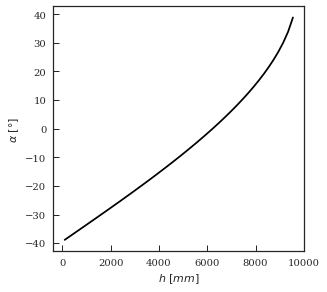

In [4]:
ca = CapillaryAction(medium, pipette)
h_span = np.linspace(1e-1, 2e1, 100)
alpha_span = ca._calculate_alpha(h_span)
ca.plot(h_span*1e3, alpha_span, r"$h\ [mm]$", r"$\alpha\ [\degree]$")

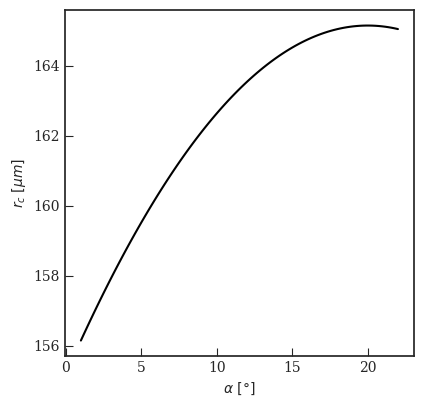

In [7]:
ca = CapillaryAction(medium, pipette)
alpha_span = np.linspace(1, 22, 100)
rc_span = ca._calculate_constriction(alpha_span)
ca.plot(alpha_span, rc_span*1e6, r"$\alpha\ [\degree]$", r"$r_c\ [\mu m]$",)

# Nanoparticle Heaters Model
Model of single nanoparticle as a heater. For references, see OneNote notebook and Zotero (tag:nannoparticles.)

In [1]:
import sys
sys.path.append("..")
from sicm.plots import plot_generic

import numpy as np

%load_ext autoreload
%autoreload 2

In [3]:
def calculate_temperature_increase(I, sigma, kappa, r):
    """Calculate temperature increase around single plasmonic NP
    
    Parameters
    ----------------
    I: float
        incident power density in W/cm2
    sigma: float
        Absorption cross section in cm2
    kappa: float
        Heat conductivity in W/(m.K)
    r: float or array-like
        Distances at which to calculate temperature increase, in nm
    
    Returns
    -----------------
    T_delta: float or array-like
        Temperature increase at distances r, in K
    """
    r = r * 1e-7 # convert nanometers to centimeters
    T_increase = (I * sigma) / (4 * np.pi * kappa) * (1/ r)
    return T_increase

def calculate_power_density(P, d):
    """Calculate power density supplied by laser
    
    Parameters
    ----------
    P: float
        Power in W
    d: float
        Laser spot diameter at focal plane, in mm
    
    Returns
    ----------
    rho: float
        Power density in W/cm2
    """
    d = d / 10 # convert mm to cm
    A = np.pi * (d / 2)**2
    rho = P / A
    return rho

def plot_temperature(r, T, x_lab = r"$r\ [nm]$", y_lab = r"$\Delta T\ [K]$",):
    """Render plot of r vs T"""
    plot_generic([r], [T], [x_lab], [y_lab])

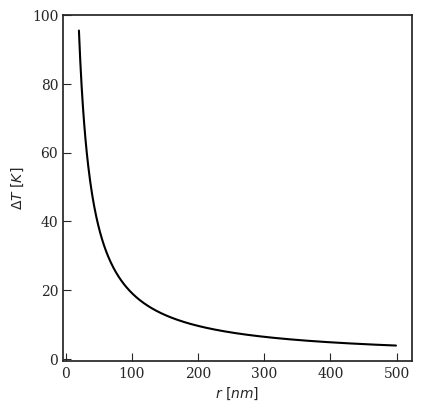

In [5]:
P = 0.5 # power in watts
transmitance = 0.85 # transmitace at given wavelength
d = 0.575 # laser spot diameter in mm
sigma = 8.8e-6 # absorption cross section in cm2
kappa = 0.6 # thermal conductivity of medium
r = np.arange(20, 500, 1) # distance in nm

I = calculate_power_density(P * transmitance, d)
T_delta = calculate_temperature_increase(I, sigma, kappa, r)
plot_temperature(r, T_delta)


# Gaussian Beam Model

Fit gaussian beam to an image data.
For assigning window extents, use infromation from: `S:\UsersData\Martin\2019\03_Mar\15\tip_opening\calibration_grid\scale_settings.png`:
    -window size = $139.75 x 104.80 \mu m$.

In [1]:
import sys
sys.path.append("..")
from sicm import io, plots
import numpy as np
import matplotlib.pyplot as plt

from sicm.models.beam import GaussianBeam

import skimage

%load_ext autoreload
%autoreload 2

In [23]:
datadir = "S:\\UsersData\\Martin\\2019\\05_May\\14"
exp_name = "laser_beam_40x_4p96AU.png"

# datadir = r"S:\UsersData\Martin\2019\05_May\08"
# exp_name = "laser_location.png"
gb = GaussianBeam(datadir, exp_name, is_debug = True)

In [25]:
gb.thresh()

C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


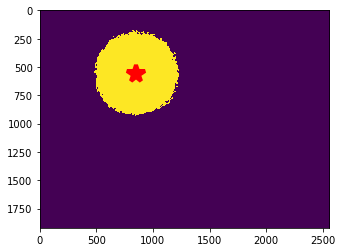

In [26]:
gb.fit_circle()

In [30]:
gb.convert_to_polar(139.75e-6, 104.8e-6, double_sided = True)

### Results
Ok, So I think I implemented everything correctly, but I am not getting anywhere with this because:

* the image is saturated
* the data is plain png, no information on camera calibration, raw_values

As this is not crucial at this point, I suggest to halt this. I can try to save it as tiff sometimes later.

In [31]:
gb.remove_saturated(250)

In [32]:
gb.remove_edges(50e-6)

Fitting _gaussian_beam_model to 133278 datapoints ...
Found parameters: [1.56755349e-06 6.79617478e-05].
Finished in 0.103 s
error on fit: 8.253986705E+02


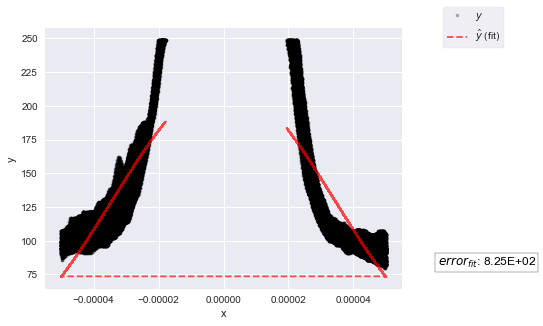

FWHM = 8.002e-05 m


In [33]:
gb.fit_model()
print("FWHM = {:.3e} m".format(gb.fwhm))

# Guassian Beam for Intensity Image

In [14]:
import sys
sys.path.append("..")
from sicm import io, plots
import numpy as np
import matplotlib.pyplot as plt

from sicm.models.beam import GaussianBeam

import skimage

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
datadir = r"S:\UsersData\Martin\2019\06_June\25\Intensity_measurements" + r"\quick_save_img_container"
exp_name = "sweep3_14"
gb = GaussianBeam(datadir, exp_name, is_debug = True)

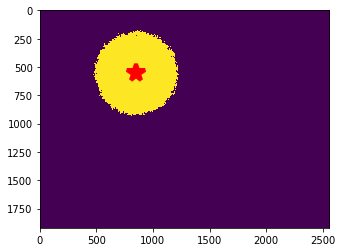

In [39]:
gb.thresh()
gb.fit_circle()

#  Getting Power



This is a trivial way how to obtain the power, but for now sufficient.

Ideally fit beam and get power at FWHM. 

In [45]:
factor = 1
factor *= 1 / 0.9 # once through hot mirror
factor *= 1e4 # once through OD4 filter
factor *= 1e-4 # convert to W/cm2
np.mean(gb.img[gb.mask]) * factor

287.0344967909096

# Debye Length

In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
eps_r = 80.2 # -
eps_0 =  8.8541878128e-12 # F/m
eps = eps_r * eps_0
e = 1.60217662e-19 # C
N_A = 6.0221409e23 # 1/mol
c = 0.25 # M
z = 1 # -
T = 298.15 # K
R = 8.314462618 # J/(K*mol)
I_c = lambda x: 0.5 * ((x*z)+(x*z)) # 2 component salt KCl

In [22]:
c = np.logspace(-9, 0)
lambda_D = lambda x: np.sqrt((eps * R * T) / (2 * e**2 * N_A**2 * I_c(x)))

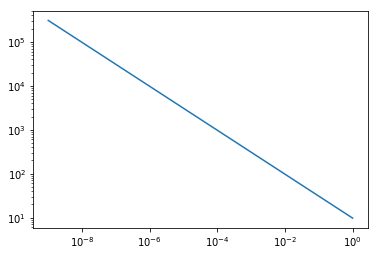

In [23]:
plt.loglog(c, lambda_D(c) * 1e9)

# Thermophoresis, Soret coefficient

In [29]:
import sys
sys.path.append("..")

import numpy as np
from sicm.plots.plots import plot_generic
from sicm.utils.utils import make_fname

In [30]:
def S_T(T):
    """Caclulate value of Soret's coefficient at given temperature
    
    Equation from Roemer at al, 2013. Possibly valid only for c = 0.5M!
    However, it gives a reasonable value and this I stick with it.
    """
    T_sign_reverse = 293 # K, temeprature at which S_T reverses sign
    gamma = 167 #102 # K, miscelaneous parameter
    S_T_inf = 0.016 #0.0098 # high-T thermophobic limit
    S_T = S_T_inf * (1 - np.exp((T_sign_reverse - T) / gamma))
    return S_T

def c_salt(T, c0, T0):
    """Calculate adjusted concentration due to thermophoresis"""
    c = c0 * np.exp(-S_T(T) * (T - T0))
    return c

In [31]:
T = np.arange(298.15, 320, 1)
c0 = 0.25
T0 = 298.15
datadir = r"S:\UsersData\Martin\projects\thermometry\comsol\study12\results"
fname_base = datadir + r"\plots"

Saved figure to S:\UsersData\Martin\projects\thermometry\comsol\study12\results\plots_st.svg.


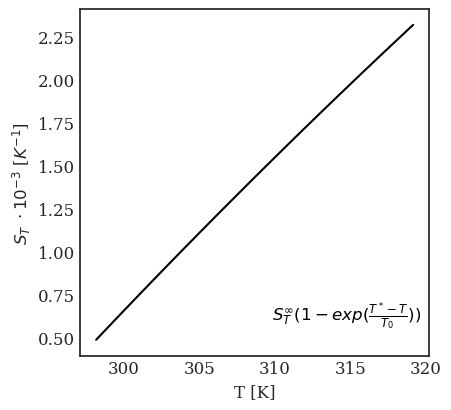

In [32]:
fname = make_fname(fname_base , "_st", ".svg")
text = r"$S_T^{\infty}(1 - exp(\frac{T^* - T}{T_0}))$"
plot_generic([T], [S_T(T)*1e3], ["T [K]"], [r"$S_T\ \cdot10^{-3}$ [$K^{-1}$]"],
            text = text, text_loc = (0.55, 0.1), fname = fname)

Saved figure to S:\UsersData\Martin\projects\thermometry\comsol\study12\results\plots_c.svg.


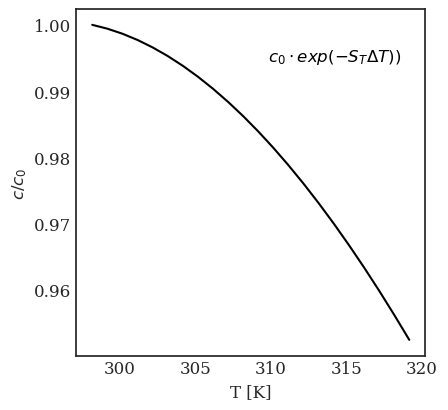

In [33]:
fname = make_fname(fname_base, "_c", ".svg")
text = r"$c_0\cdot exp(-S_T \Delta T))$"
plot_generic([T], [c_salt(T, c0, T0) / c0], ["T [K]"], [r"$c/c_0$"],
            text = text, text_loc = (0.55, 0.85), fname = fname)

# Transient Heat Conduction in Semi-Infinite Solid

Model unsteady heat distribution in a solid that has a temperature T applied to one of its edges.

See the [presentation, slide 41-47](https://www.slideshare.net/TarikuNegash/chapter-4-transient-heat-condution) for approach.

For $\alpha$ we use value from [Wikipedia](https://en.wikipedia.org/wiki/Thermal_diffusivity)

In [3]:
import sys
sys.path.append("..")
from sicm.plots import plots

import numpy as np
from scipy.special import erf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def nu(x, t, alpha = 1.43e-7):
    """Dimensionless variable"""
    return x / np.sqrt(4 * alpha * t)

def T(T_i, T_s, x, t):
    temp = (T_i - T_s) * erf(nu(x, t)) + T_s
    return temp   


In [19]:
d = 15e-9 # 15 nm from surface
t = np.logspace(-2, 3, 100) # time in seconds

T_amb = 273.15
dT_i = 25.0
dT_s = 37.0

x = t
y = T(T_amb + dT_i, T_amb + dT_s, d, t) - (T_amb + dT_i)

txt = "z = {:.0f} nm".format(d * 1e9)

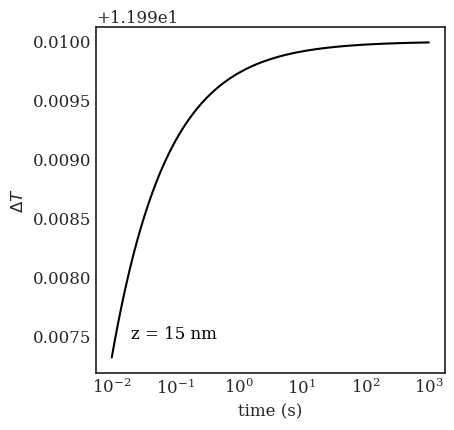

In [20]:
plots.plot_generic([x], [y], ["time (s)"], [r"$\Delta T$"], text = txt, scale = "logx")

------
## Archived Approach

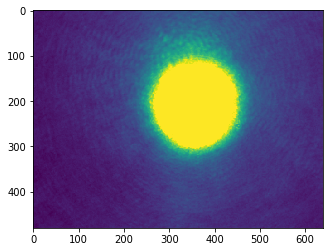

In [3]:
datadir = "S:\\UsersData\\Martin\\2019\\05_May\\14"
exp_name = "laser_beam_40x_4p96AU.png"
img = io.rgb2gray(io.load_image(datadir, exp_name))
plt.imshow(img)

Ok this is fine. next you should bedoing something like

```python
thresh = skimage.thresh(moving_average(img))
img_binary = img > threhs
center, radius = fit_circle(img_binary)
img_rcoords = convert_to_polar(img, center, y)

gbeam = GaussianBeam(img_coords, img)

gbeam.fit()
print(gbeam.fwhm)
```

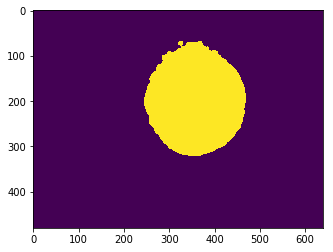

In [16]:
from skimage.morphology import square
img_filt = skimage.filters.rank.mean(img, square(10))
thresh = skimage.filters.threshold_otsu(img_filt)
img_binary = img_filt > thresh
plt.imshow(img_binary)